In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

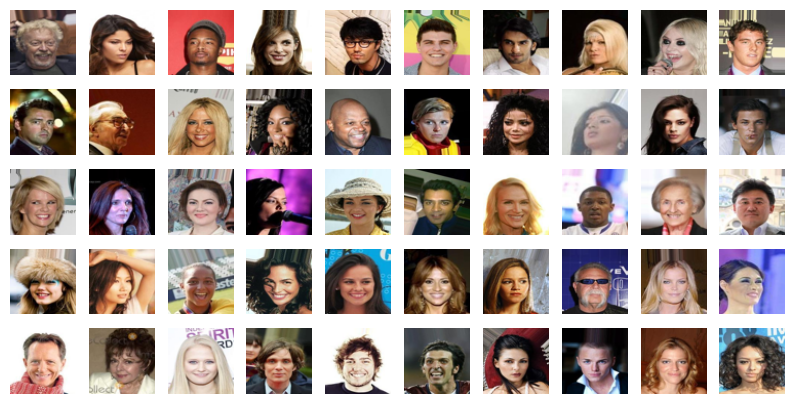

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
cls = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Flatten(),
    torch.nn.Linear(512, 1),
)

cls(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 1])

In [5]:
class Block(torch.nn.Module):

    def __init__(self, dim_in, dim_out):
        super().__init__()

        def block(dim_in, dim_out, kernel_size=3, stride=1, padding=1):
            return (
                torch.nn.ConvTranspose2d(dim_in,
                                         dim_out,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding),
                torch.nn.BatchNorm2d(dim_out),
                torch.nn.LeakyReLU(),
            )

        self.s = torch.nn.Sequential(
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_out, kernel_size=3, stride=2, padding=0),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
        )

        self.res = torch.nn.ConvTranspose2d(dim_in,
                                            dim_out,
                                            kernel_size=3,
                                            stride=2,
                                            padding=0)

    def forward(self, x):
        return self.s(x) + self.res(x)


gen = torch.nn.Sequential(
    torch.nn.Linear(128, 256 * 4 * 4),
    torch.nn.InstanceNorm1d(256 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
    Block(256, 128),
    Block(128, 64),
    Block(64, 32),
    Block(32, 3),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

gen(torch.randn(2, 128)).shape

torch.Size([2, 3, 64, 64])

In [6]:
def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad_(requires_grad)


def wasserstein(pred, label):
    return -(pred * label).mean()


#修改优化器类型
optimizer_cls = torch.optim.Adam(cls.parameters(), lr=2e-4)
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=2e-4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

cls.to(device)
gen.to(device)

cls.train()
gen.train()

device

'cuda'

In [7]:
def get_gradient_penalty(real, fake):
    #real -> [64, 3, 64, 64]
    #fake -> [64, 3, 64, 64]

    r = torch.rand((64, 1, 1, 1), device=device)
    r.requires_grad = True

    #[64, 3, 64, 64]
    merge = r * real + (1 - r) * fake

    #[64, 3, 64, 64] -> [64, 1]
    pred = cls(merge)

    grad = torch.autograd.grad(inputs=merge,
                               outputs=pred,
                               grad_outputs=torch.ones(64, 1, device=device),
                               create_graph=True,
                               retain_graph=True)

    #[64, 3, 64, 64] -> [64, 12288]
    grad = grad[0].reshape(64, -1)

    #[64, 12288] -> [64]
    grad = grad.norm(p=2, dim=1)

    #[64] -> scala
    return (1 - grad).pow(2).mean()


get_gradient_penalty(torch.randn(64, 3, 64, 64, device=device),
                     torch.randn(64, 3, 64, 64, device=device))

tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
def train_cls():
    set_requires_grad(cls, True)
    set_requires_grad(gen, False)

    #得到三份数据
    data_real = next(iter(loader)).to(device)
    with torch.no_grad():
        data_fake = gen(torch.randn(64, 128, device=device))

    #分别计算
    pred_real = cls(data_real)
    pred_fake = cls(data_fake)

    #求loss,加权求和
    loss_real = wasserstein(pred_real, torch.ones(64, 1, device=device))
    loss_fake = wasserstein(pred_fake, -torch.ones(64, 1, device=device))
    loss_grad = get_gradient_penalty(data_real, data_fake)

    loss = loss_fake + loss_real + loss_grad * 10

    loss.backward()
    optimizer_cls.step()
    optimizer_cls.zero_grad()

    return loss.item()


train_cls()

9.877996444702148

In [9]:
def train_gen():
    set_requires_grad(cls, False)
    set_requires_grad(gen, True)

    pred = cls(gen(torch.randn(64, 128, device=device)))

    loss = wasserstein(pred, torch.ones(64, 1, device=device))
    loss.backward()
    optimizer_gen.step()
    optimizer_gen.zero_grad()

    return loss.item()


train_gen()

0.08535409718751907

0 0.8798155784606934 5.204181671142578


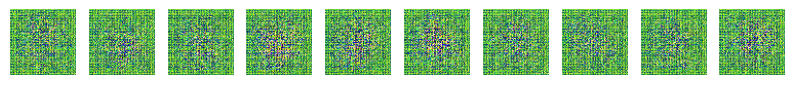

10000 -26.04679298400879 10.231369018554688


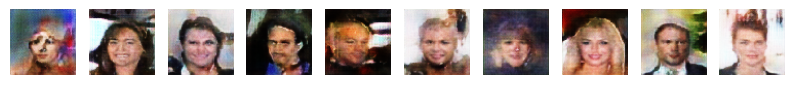

20000 -40.636844635009766 17.289649963378906


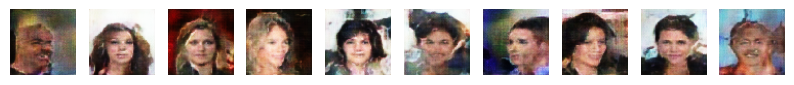

30000 -34.9294548034668 19.96688461303711


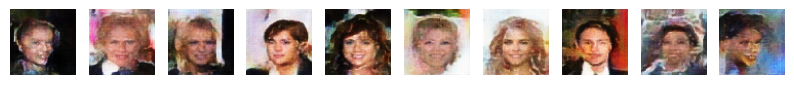

40000 -38.78118133544922 28.815258026123047


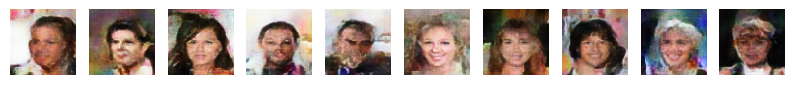

50000 -47.87330627441406 26.003253936767578


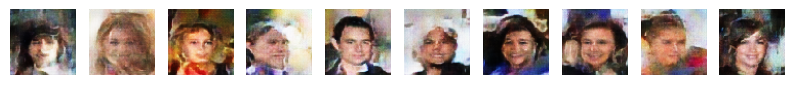

60000 -52.101097106933594 30.648014068603516


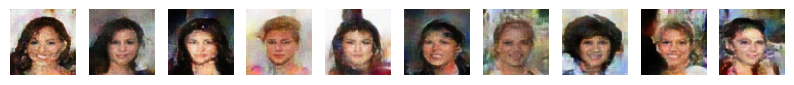

70000 -48.94269943237305 30.102218627929688


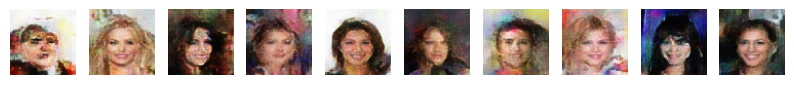

80000 -52.29653549194336 32.998985290527344


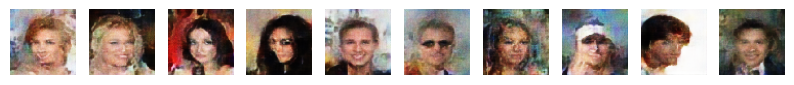

90000 -52.0606689453125 36.16505432128906


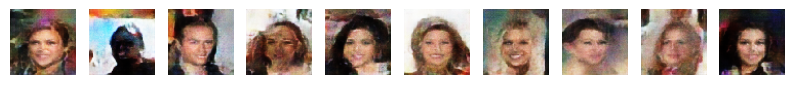

100000 -49.05194091796875 32.11138153076172


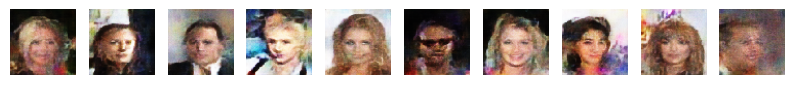

110000 -46.27825164794922 36.322540283203125


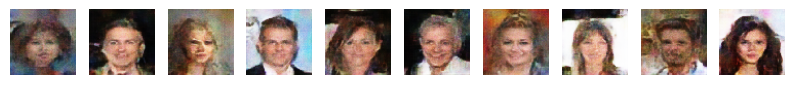

120000 -46.96208953857422 39.49036407470703


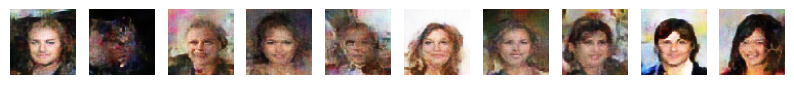

130000 -46.886505126953125 39.07115936279297


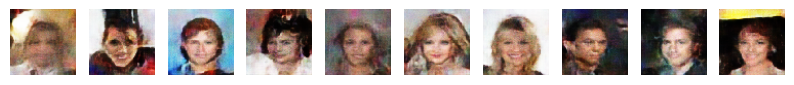

140000 -45.34870147705078 39.76750946044922


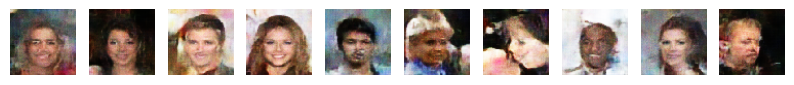

150000 -40.49600601196289 44.40778732299805


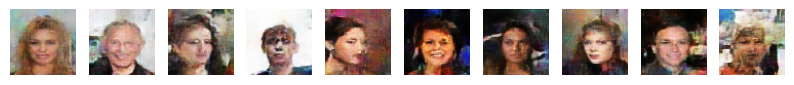

160000 -42.85284423828125 37.53781509399414


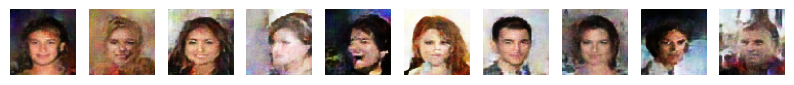

170000 -39.95947265625 37.90868377685547


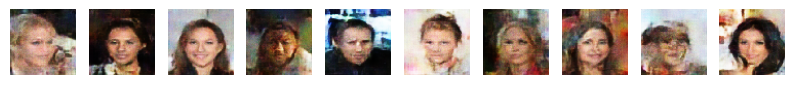

180000 -41.05640411376953 40.19596481323242


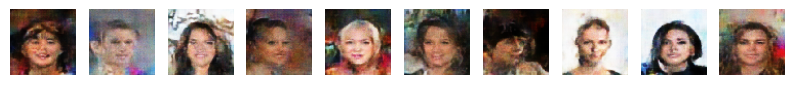

190000 -38.975120544433594 42.34258270263672


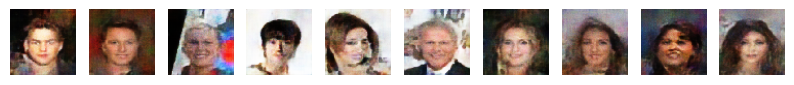

In [10]:
def train():
    for epoch in range(20_0000):
        for _ in range(5):
            loss_cls = train_cls()

        loss_gen = train_gen()

        if epoch % 1_0000 == 0:
            print(epoch, loss_cls, loss_gen)
            with torch.no_grad():
                pred = gen(torch.randn(10, 128, device=device))
            show(pred)


local_training = True

if local_training:
    train()

In [11]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.cls = cls.to('cpu')
        self.gen = gen.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.5.wgangp',
        use_auth_token=open('/root/hub_token.txt').read().strip())

pytorch_model.bin:   0%|          | 0.00/43.7M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

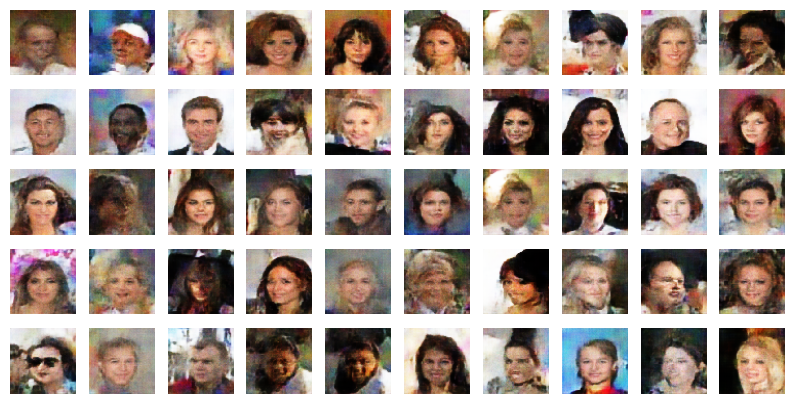

In [12]:
#加载训练好的模型
gen = Model.from_pretrained('lansinuote/gen.5.wgangp').gen

with torch.no_grad():
    pred = gen(torch.randn(50, 128))
    
show(pred)